### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра информационных технологий 

## ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ № 2


### Дисциплина: Методы машинного обучения

##### Студент:  Пономарева Л. М.
##### Группа:   НПИбд-02-19

## Москва 2022
***

## Вариант №22

1. Набор данных: howell 

2. Независимая переменная: height 

3. Зависимая переменная: weight 

4. Визуализация для независимой переменной – диаграмма размаха 

5. Визуализация для зависимой переменной – эмпирическая функция распределения 

6. Показатель качества регрессии – MSE (mean squared error)

### Задание 1
Загрузите заданный в индивидуальном задании набор данных из Tensorflow Datasets.

Активируем последние версии наборов данных и подключаем модуль Tensorflow Datasets, который содержит необходимый нам набор 'howell':

In [1]:
!pip install -q tfds-nightly
import tensorflow_datasets as tfds

     |████████████████████████████████| 4.3 MB 33.7 MB/s 
     |████████████████████████████████| 86 kB 4.4 MB/s 


Считываем из TFDS набор данных howell:

In [2]:
dataSet = tfds.load('howell', split='train')
dataSet

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/544 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/howell/1.0.0.incompleteO8SZV1/howell-train.tfrecord*...:   0%|          | 0/54…

Dataset howell downloaded and prepared to ~/tensorflow_datasets/howell/1.0.0. Subsequent calls will reuse this data.


<PrefetchDataset element_spec={'age': TensorSpec(shape=(), dtype=tf.float32, name=None), 'height': TensorSpec(shape=(), dtype=tf.float32, name=None), 'male': TensorSpec(shape=(), dtype=tf.int32, name=None), 'weight': TensorSpec(shape=(), dtype=tf.float32, name=None)}>

Преобразуем объект PrefetchDataset в датафрейм:

In [52]:
dataFrame = tfds.as_dataframe(dataSet)
dataFrame.head()

,age,height,male,weight
0,20.0,154.899994,1,38.200001
1,21.0,155.574997,0,45.529297
2,21.0,146.050003,0,44.763859
3,21.0,163.830002,1,46.776676
4,18.0,149.225006,0,42.127357


### Задание 2
Выполните визуализацию независимой и зависимой переменных в соответствии с индивидуальным заданием, подписывая оси и рисунок. 

Независимая переменная: height  
Визуализация – диаграмма размаха  

Зависимая переменная: weight   
Визуализация – эмпирическая функция распределения 

Подключаем необходимые библиотеки в том числе Matplotlib, предназначенную для визуализации данных:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Создаем два массива с данными о наших параметрах:

In [5]:
h = dataFrame['height'].to_numpy()
w = dataFrame['weight'].to_numpy()

Создадим функцию, вычисляющую значения функции распределения для переменной weight:

In [6]:
def ECDF(data, x):
    counter = 0
    for v in data:
        if v <= x:
            counter += 1
    return counter / len(data)

Зададим массивы значений для визуализации функции распределения:

In [7]:
npoints = 500
dx = (w.max()-w.min())/npoints

xlist = [w.min()+dx*i for i in range(npoints)]
ylist = [ECDF(w, x) for x in xlist]

Выполним визуализацию независимой и зависимой переменных:

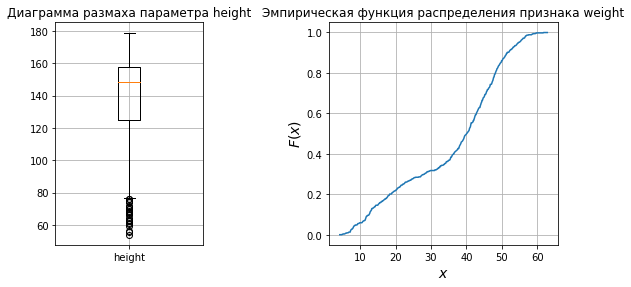

In [8]:
plt.figure(figsize=(9, 9))
plt.subplot(2, 3, 1)          # график №1
plt.boxplot(h)  # построение диаграммы размаха
plt.title("Диаграмма размаха параметра height") # заголовок
plt.xticks([1], ['height']) # подпись тика на оси абсцисс
plt.grid(True)                # включение отображение сетки
plt.subplot(2, 2, 2)          # график №2
plt.plot(xlist, ylist)               # построение графика функции распределения
plt.title("Эмпирическая функция распределения признака weight")
plt.xlabel(r"$x$", fontsize=14)  # ось абсцисс
plt.ylabel(r"$F(x)$", fontsize=14) # ось ординат
plt.grid(True);   

### Задание 3
Постройте парную линейную регрессию для независимой и зависимой переменных при помощи точного подхода и при помощи нейронной сети с одним нейроном. Вычислите и сравните значения показателей качества R^2 двух подходов.

#### Точный подход

Добавим класс, позволяющий вычислять коэффициенты $a,\,b$ парной линейной регрессии $y=a\,x+b$ и прогнозировать значение  $y$  по любому значению  $x$:

In [9]:
class SimpleLinReg:

    def __init__(self):
        self.a_ = None
        self.b_ = None

    def fit(self, x_train, y_train):
        assert x_train.ndim == 1, \
            "В данных должен быть один признак"
        assert len(x_train) == len(y_train), \
            "Данные должны иметь одинаковый размер"

        x_mean = np.mean(x_train)
        y_mean = np.mean(y_train)

        self.a_ = (x_train - x_mean).dot(y_train - y_mean) / \
                  (x_train - x_mean).dot(x_train - x_mean)
        self.b_ = y_mean - self.a_ * x_mean

        return self

    def predict(self, x_predict):
        assert x_predict.ndim == 1, \
            "В данных должен быть один признак"
        assert self.a_ is not None and self.b_ is not None, \
            "Модель вначале должна быть обучена"

        return np.array([self._predict(x) for x in x_predict])

    def _predict(self, x_single):
        return self.a_ * x_single + self.b_

    def __repr__(self):
        return "SimpleLinearReg()"

Создадим объект класса SimpleLinReg и построим функцию парной регрессии:

In [10]:
reg1 = SimpleLinReg()
reg1.fit(h, w)
reg1.a_, reg1.b_

(0.5016993, -33.756134)

Выполним прогнозировние значений переменной weight

In [31]:
w_hat1 = reg1.predict(h)

#### Нейронная сеть

Рассмотрим задачу регрессии для набора howell с использованием средств Tensorflow.

Подключим библиотеку Tensorflow

In [12]:
import tensorflow as tf
print(tf.__version__)

2.8.0


Создадим с использованием средств модуля Keras модель простейшей нейронной сети из одного слоя с одним нейроном:

In [13]:
model = tf.keras.Sequential( [ tf.keras.layers.Dense(1, input_shape=(1,)) ] )

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


После того, как модель построена, настроим процесс ее обучения вызовом метода compile():

In [15]:
model.compile(
    loss=tf.keras.losses.mean_absolute_error, # для оценки качества модели используется средняя абсолютная ошибка MAE
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.25),
    metrics=['mean_absolute_error']
)

Обучим модель, используя метод fit():

In [16]:
model.fit(h, w, epochs=100)

Epoch 1/100
17/17 [==============================] - 1s 2ms/step - loss: 11.0386 - mean_absolute_error: 11.0386
Epoch 2/100
17/17 [==============================] - 0s 1ms/step - loss: 8.1533 - mean_absolute_error: 8.1533
Epoch 3/100
17/17 [==============================] - 0s 1ms/step - loss: 7.3515 - mean_absolute_error: 7.3515
Epoch 4/100
17/17 [==============================] - 0s 1ms/step - loss: 6.8269 - mean_absolute_error: 6.8269
Epoch 5/100
17/17 [==============================] - 0s 2ms/step - loss: 7.2904 - mean_absolute_error: 7.2904
Epoch 6/100
17/17 [==============================] - 0s 1ms/step - loss: 6.6105 - mean_absolute_error: 6.6105
Epoch 7/100
17/17 [==============================] - 0s 2ms/step - loss: 6.7621 - mean_absolute_error: 6.7621
Epoch 8/100
17/17 [==============================] - 0s 1ms/step - loss: 7.0283 - mean_absolute_error: 7.0283
Epoch 9/100
17/17 [==============================] - 0s 1ms/step - loss: 6.1814 - mean_absolute_error: 6.1814
Epoch 10

Выполним прогнозирование значений зависимой переменной (отклика):

In [32]:
w_hat2 = model.predict(h)

#### Сравнение значений показателей качества $R^2$ двух подходов:

Вычислим значение показателей качества $R^2$ двух подходов:
1. Вычислим среднюю квадратичную ошибку (MSE)

In [35]:
mse_test1 = np.sum((w_hat1 - w)**2) / len(w)  # для точного подхода
print("MSE точного подхода = ", mse_test1)
mse_test2 = np.sum((w_hat2 - w)**2) / len(w)  # для нейронной сети
print("MSE нейронной сети = ", mse_test2)

MSE точного подхода =  24.8377685546875
MSE нейронной сети =  219168.36764705883


2. Вычислим коэффициенты детерминации $R^2$:

In [38]:
R1 = 1 - mse_test1/np.var(w)
print("R^2 точного подхода = ", R1)
R2 = 1 - mse_test2/np.var(w)
print("R^2 ANN = ",R2)

R^2 точного подхода =  0.885146427424846
R^2 ANN =  -1012.4674523722017


### Задание  4
Постройте диаграмму рассеяния для независимого и зависимого признаков и изобразите линии двух построенных парных регрессий, подписывая оси и рисунок и создавая легенду. 

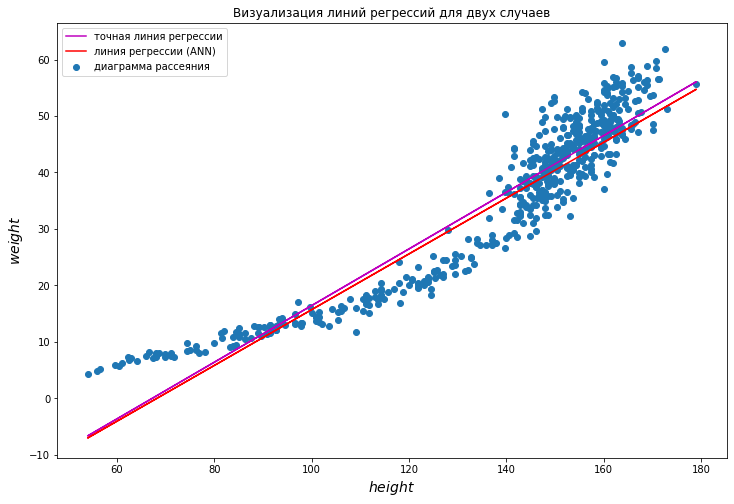

In [25]:
plt.figure(figsize=(12,8)) # size
plt.scatter(h, w, label='диаграмма рассеяния')
plt.xlabel(r"$height$", fontsize=14)
plt.ylabel(r"$weight$", fontsize=14)
plt.title('Визуализация линий регрессий для двух случаев')
plt.plot(h, w_hat1, c='m', label='точная линия регрессии')
plt.plot(h, w_hat2, c='r', label='линия регрессии (ANN)')
plt.legend();

### Задание 5 
Разбейте набор признаков на обучающую и контрольную выборки. Создайте и адаптируйте на обучающей выборке нормализующий слой Tensorflow для всех признаков набора данных (за исключением зависимого признака). 

Функция разбиения данных на обучающую и контрольную выборки:

In [39]:
def train_test_split(X, y, test_ratio=0.2, seed=None): 
    """returns X_train, X_test, y_train, y_test""" 
    assert X.shape[0] == y.shape[0], \
        "Размер X должен быть равен размеру y"
    assert 0.0 <= test_ratio <= 1.0, \
        "Неверное значение test_ratio"

    if seed: 
        np.random.seed(seed)

    shuffled_indexes = np.random.permutation(len(X))
    test_size = int(len(X) * test_ratio) 

    test_indexes = shuffled_indexes[:test_size] 
    train_indexes = shuffled_indexes[test_size:]

    X_train = X[train_indexes] 
    y_train = y[train_indexes]

    X_test = X[test_indexes] 
    y_test = y[test_indexes]

    return X_train, X_test, y_train, y_test

Создадим четыре массива:  
- x_train – массив значений признаков (предикторов) для обучения;  
- y_train - массив значений отклика для x_train;
- x_test – массив значений признаков (предикторов) для тестирования;
- y_test - массив значений отклика для x_test.

In [104]:
df = dataFrame.drop(['weight'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(df.to_numpy(), w)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((436, 3), (436,), (108, 3), (108,))

Создадим на обучающей выборке нормализующий слой Tensorflow для всех признаков набора данных (за исключением зависимого признака).

Создадим слой нормализации:

In [105]:
normalizer = tf.keras.layers.Normalization()

Преобразуем массив x_train в датафрейм:

In [106]:
df_train = pd.DataFrame(x_train)
df_train

,0,1,2
0,37.0,147.955002,0.0
1,16.0,153.669998,0.0
2,46.0,153.035004,0.0
3,50.0,167.005005,1.0
4,56.0,147.955002,0.0
...,...,...,...
431,54.0,159.399994,1.0
432,21.0,155.574997,0.0
433,24.0,160.654999,1.0
434,35.0,163.830002,1.0


Адаптируем слой ко всем (кроме зависимого) признакам набора данных:

In [118]:
normalizer.adapt(df_train)

Оценим эффект нормализации:

In [121]:
df_train[0:5]

,0,1,2
0,37.0,147.955002,0.0
1,16.0,153.669998,0.0
2,46.0,153.035004,0.0
3,50.0,167.005005,1.0
4,56.0,147.955002,0.0


In [120]:
normalizer(df_train[0:5]).numpy()

array([[ 0.39909127,  0.34696844, -0.9595337 ],
       [-0.63818914,  0.5544823 , -0.9595337 ],
       [ 0.84364   ,  0.5314254 , -0.9595337 ],
       [ 1.0412172 ,  1.0386819 ,  1.0421729 ],
       [ 1.3375831 ,  0.34696844, -0.9595337 ]], dtype=float32)

### Задание 6
Используя созданный нормализующий слой, постройте и обучите на обучающей выборке регресоры на базе следующих моделей множественной регрессии:
  * линейной регрессии
  * гребневой регрессии (L2)
  * лассо регрессии (L1)



#### Линейная регрессия

Построим последовательную модель с двумя слоями:

In [122]:
linear_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(units=1)
])
linear_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 3)                7         
 ion)                                                            
                                                                 
 dense_10 (Dense)            (None, 1)                 4         
                                                                 
Total params: 11
Trainable params: 4
Non-trainable params: 7
_________________________________________________________________


Вызовем модель для набора входных данных:

In [124]:
linear_model.predict(df_train[:10])

array([[ 0.66212606],
       [ 1.4143503 ],
       [ 0.27227172],
       [-2.210734  ],
       [-0.06479428],
       [ 0.10272715],
       [ 1.2153426 ],
       [ 1.7836236 ],
       [-1.7061026 ],
       [-0.98487264]], dtype=float32)

После построения модели настроим процедуру обучения с помощью метода compile(). 

In [125]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.25),
    loss='mean_absolute_error')

После настройки обучения используем метод fit() для выполнения обучения:

In [158]:
%%time
history = linear_model.fit(
    df_train, y_train, 
    epochs=100,
    # подавляем вывод
    verbose=0,
    # проверка (валидация) на 20% обучающих данных
    validation_split = 0.2)

CPU times: user 4.2 s, sys: 191 ms, total: 4.39 s
Wall time: 4.5 s


#### Гребневая регрессия (L2)

Создаем модель с нормализацией всех признаков и регуляризацией L2:

In [146]:
l2_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(units=1, 
                          kernel_regularizer=tf.keras.regularizers.L2(l2=0.01))
])

Компилируем:

In [147]:
l2_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.25),
    loss='mean_absolute_error')

Обучаем модель:

In [148]:
%%time
history2 = l2_model.fit(
    df_train, y_train, 
    epochs=100,
    # подавляем вывод
    verbose=0,
    # проверка (валидация) на 20% обучающих данных
    validation_split = 0.2)

CPU times: user 4.61 s, sys: 216 ms, total: 4.83 s
Wall time: 5.16 s


#### Лассо регрессии (L1)

Создаем модель с нормализацией всех признаков и регуляризацией L1:

In [131]:
l1_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(units=1, 
                          kernel_regularizer=tf.keras.regularizers.L1(l1=0.01))
])

Компилируем:

In [132]:
l1_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.25),
    loss='mean_absolute_error')

Обучаем модель:

In [133]:
%%time
history1 = l1_model.fit(
    df_train, y_train, 
    epochs=100,
    # подавляем вывод
    verbose=0,
    # проверка (валидация) на 20% обучающих данных
    validation_split = 0.2)

CPU times: user 4.25 s, sys: 232 ms, total: 4.49 s
Wall time: 5.47 s


### Задание 7 
Определите  на контрольной выборке модель множественной регрессии с наиболее высоким качеством по показателю, указанному в индивидуальном задании, среди построенных моделей.

*Показатель качества регрессии – MSE (mean squared error)*

In [200]:
linear_pr = linear_model.predict(x_test)
l2_pr = l2_model.predict(x_test)
l1_pr = l1_model.predict(x_test)
mse_test_linear = np.sum((linear_pr - y_test)**2) / len(y_test)
mse_test_l2 = np.sum((l2_pr - y_test)**2) / len(y_test)
mse_test_l1 = np.sum((l1_pr - y_test)**2) / len(y_test)
print("Показатель качества регрессии линейной регрессии = ", mse_test_linear)
print("Показатель качества регрессии гребневой регрессии = ", mse_test_l2)
print("Показатель качества регрессии лассо регрессии = ", mse_test_l1)

Показатель качества регрессии линейной регрессии =  43485.49537037037
Показатель качества регрессии гребневой регрессии =  39809.416666666664
Показатель качества регрессии лассо регрессии =  42221.72222222222


### Задание 8 
Для лучшего регрессора визуализируйте кривые обучения (в зависимости от эпохи обучения).



Визуализируем ход обучения модели L2, используя статистику, хранящуюся в объекте history2.

In [165]:
hist = pd.DataFrame(history2.history)
hist['epoch'] = history2.epoch
hist

,loss,val_loss,epoch
0,34.635399,32.806087,0
1,31.820978,30.188086,1
2,29.042795,27.502119,2
3,26.315453,24.834557,3
4,23.626900,22.223673,4
...,...,...,...
95,5.400801,5.396867,95
96,5.428760,5.403248,96
97,5.427770,5.411155,97
98,5.463623,5.391746,98


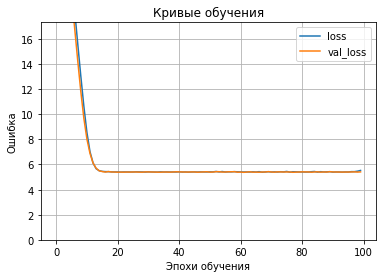

In [166]:
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.ylim([0, max(history2.history['loss'])*0.5])
plt.title('Кривые обучения')
plt.xlabel('Эпохи обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.grid(True);

### Задание 9
Определите медианные значения признаков (кроме независимого и зависимого признаков) и для построенных медианных значений визуализируйте на плоскости с независимым признаком в качестве оси абсцисс и зависимым признаком в качестве оси ординат точки тестовой выборки и линии (графики) различных моделей множественной регрессии разными цветами. Подпишите оси и создайте легенду и заголовок для рисунка.

Определим медианные значения признаков (кроме независимого и зависимого признаков):

In [185]:
df_med = df.drop('height', axis = 1).median()
df_med

age     27.0
male     0.0
dtype: float64

Создадим новую тестовую выборку со значениями признаков age и male равными их медианным значениям. Для этого создадим новый dataframe с отфильтрованными значениями:

In [225]:
DataFrame = dataFrame[dataFrame['age']==df_med[0]]
newDataFrame = DataFrame[DataFrame['male']==df_med[1]]
newDataFrame

,age,height,male,weight
156,27.0,142.875000,0,38.838814
279,27.0,144.145004,0,37.194546
287,27.0,153.669998,0,41.333572
332,27.0,149.225006,0,42.155708
396,27.0,152.399994,0,40.879978
442,27.0,150.494995,0,43.459782
508,27.0,162.559998,0,47.031822


Создадим тестовую выборку и выполним прогнозирование значений зависимой переменной, используя разные модели:

In [230]:
x_test = newDataFrame.drop('weight', axis=1)
linear_pr = linear_model.predict(x_test)
l2_pr = l2_model.predict(x_test)
l1_pr = l1_model.predict(x_test)

Уберем из тестовой выборки константные значения:

In [243]:
x_t = x_test.filter(items=['height']).to_numpy()
x_t

array([[142.875],
       [144.145],
       [153.67 ],
       [149.225],
       [152.4  ],
       [150.495],
       [162.56 ]], dtype=float32)

Визуализируем на плоскости с независимым признаком в качестве оси абсцисс и зависимым признаком в качестве оси ординат точки тестовой выборки и линии (графики) различных моделей множественной регрессии.

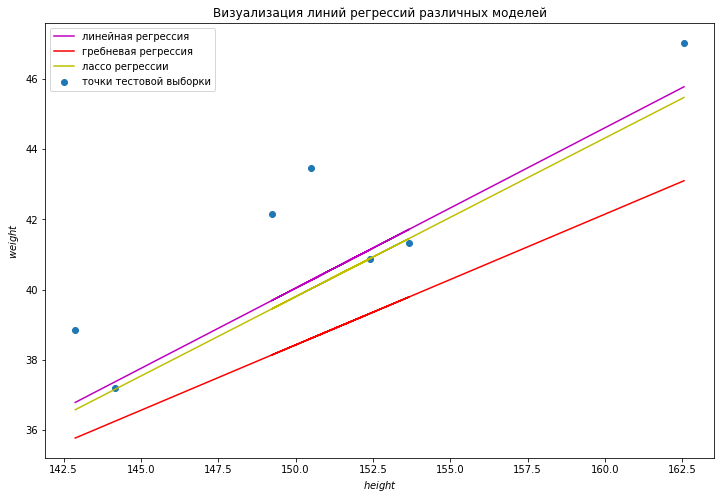

In [245]:
plt.figure(figsize=(12,8)) # size
plt.scatter(newDataFrame['height'], newDataFrame['weight'], label = "точки тестовой выборки")
plt.title('Визуализация линий регрессий различных моделей')
plt.plot(x_t, linear_pr, c='m', label='линейная регрессия')
plt.plot(x_t, l2_pr, c='r', label='гребневая регрессия')
plt.plot(x_t, l1_pr, c='y', label='лассо регрессии')
plt.xlabel(r"$height$")
plt.ylabel(r"$weight$")
plt.legend();